# INIT

In [1]:
include("../alpcahFamily.jl")
include("../helperFunctions.jl")
using Plots
using Random
using Distributions
using LinearAlgebra
using MIRT
using HePPCAT
using ProgressMeter
using LaTeXStrings
using JLD

N = 500 # total points
D = 100 # ambient space
d = 10 # subspace rank
ν1 = 1 # 0.25 ORIGINAL
ν2 = 100
goodpts = 50 # 10 ORIGINAL
trials = 25;
ν = vcat(ν1*ones(goodpts), ν2*ones(N-goodpts));

# RPCA

In [2]:
function POGM_RPCA(Y, λr, r; niter::Int=100)
    M,N = size(Y)
    A = hcat(Matrix(1.0I, M, N),Matrix(1.0I, M, N))
    B = vcat(A,A)
    Lf = opnorm(B)

    T = svd(Y)
    L = T.U[:,1:r]*Diagonal(sqrt.(T.S[1:r]))
    R = T.V[:,1:r]*Diagonal(sqrt.(T.S[1:r]))
    x0 = vcat(L*R',Y-L*R')
    
    grad = K -> repeat(-1*(Y-K[1:M,:]-K[(M+1):end,:]),2,1)
    #prox1 = (z,c) -> vcat(TSVT(z[1:M,:], c*λr, r), soft(z[M+1:end,:], c))
    prox1 = (z,c) -> vcat(SVST(z[1:M,:], c*λr), softTresh.(z[M+1:end,:], c))
    K, _ = pogm_restart(x0, x->0, grad, Lf ; g_prox=prox1, niter=niter, mom=:fpgm, restart=:gr)
    K = K[1:M,:] #,K[M+1:end,:]  Outlier matrix
    return svd(K).U[:,1:r]
end

POGM_RPCA (generic function with 1 method)

# Data Generation

In [3]:
U1 = generateSubspace(D, d)
Y = generateData(U1, [ν1;ν2], [goodpts;N-goodpts]; coordinateWindow = 33, coordinateType = :uniform, seed=rand(1:100000));

In [4]:
YL = []
for i = 1:trials
    Y0 = generateData(U1, [ν1;ν2], [goodpts;N-goodpts]; coordinateWindow = 33, coordinateType = :uniform, seed=i);
    push!(YL,Y0)
end

# Small Trial

In [5]:
U_PCA = PCA(Y,d)
affinityError(U1, U_PCA)

0.32494251001683566

In [6]:
U_WPCA = weightedPCA(Y,ν,d);
affinityError(U1, U_WPCA)

0.10327746786452871

In [7]:
U_HEPPCAT = heppcatWrapper_known(Y, d, [ν1;ν2], goodpts; heppcatIter=100, varfloor= 1e-9)
affinityError(U1, U_HEPPCAT)

0.1027273622477042

In [8]:
U_ALPCAH_LR = LR_ALPCAH_KNOWN(Y,d, ν; varfloor=1e-9, alpcahIter= 10)
affinityError(U1, U_ALPCAH_LR)

0.10327746786457707

In [9]:
λr = 40;
U_ALPCAH = ALPCAH_KNOWN(Y, d, λr, ν; μ=0.01, ρ=1.01, alpcahIter=200, varfloor=1e-9)
affinityError(U1, U_ALPCAH)

0.10327746613625749

In [10]:
λr = 20;
U_RPCA = POGM_RPCA(Y, λr, d; niter=100)
affinityError(U1, U_RPCA)

0.29470108919703547

In [11]:
λr = 10;
U_ALPCAH = ALPCAH_NUCLEAR_KNOWN(Y, d, λr, ν; μ=0.01, ρ=1.01, alpcahIter=200, varfloor=1e-9)
affinityError(U1, U_ALPCAH)

0.10470293274077755

# Full Trials (MUST BE SAME LENGTH!)

In [8]:
λr_alpcah = vcat(0.0:2.5:37.5)
λr_alpcah[1] = 0.1

0.1

In [13]:
wpcaMatrix = zeros(trials)
pcaMatrix = zeros(trials)
heppcatMatrix = zeros(trials)
alpcahlrMatrix = zeros(trials)
alpcahMatrix = zeros(trials, length(λr_alpcah))
alpcahNuclearMatrix = zeros(trials, length(λr_alpcah))
rpcaMatrix = zeros(trials, length(λr_alpcah))

@showprogress for i=1:trials
    # PCA
    U_PCA = PCA(YL[i], d)
    pcaMatrix[i] = affinityError(U1, U_PCA) 
    
    # WPCA
    U_WPCA = weightedPCA(YL[i],ν,d);
    wpcaMatrix[i] = affinityError(U1, U_WPCA)
    
    # HEPPCAT
    U_HEPPCAT = heppcatWrapper_known(YL[i], d, [ν1;ν2], goodpts; heppcatIter=100, varfloor= 1e-9)
    heppcatMatrix[i] = affinityError(U1, U_HEPPCAT)

    # LR-ALPCAH
    U_ALPCAH_LR =  LR_ALPCAH_KNOWN(YL[i],d, ν; varfloor=1e-9, alpcahIter= 10)
    alpcahlrMatrix[i] = affinityError(U1, U_ALPCAH_LR)
    
    Threads.@threads for j=1:length(λr_alpcah)
        # ALPCAH
        U_ALPCAH = ALPCAH_KNOWN(YL[i], d, λr_alpcah[j], ν; μ=0.01, ρ=1.01, alpcahIter=200, varfloor=1e-9)
        alpcahMatrix[i,j] = affinityError(U1, U_ALPCAH)

        # ALPCAH NUCLEAR
        U_ALPCAH_NUC = ALPCAH_NUCLEAR_KNOWN(YL[i], d, λr_alpcah[j], ν; μ=0.01, ρ=1.01, alpcahIter=200, varfloor=1e-9)
        alpcahNuclearMatrix[i,j] = affinityError(U1, U_ALPCAH_NUC)

        # RPCA
        U_RPCA = POGM_RPCA(YL[i], λr_alpcah[j], d; niter=100)
        rpcaMatrix[i,j] = affinityError(U1, U_RPCA)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:08:09


In [15]:
save("results_known.jld", "pca", pcaMatrix, "wpca", wpcaMatrix, "heppcat", heppcatMatrix, "lr-alpcah", alpcahlrMatrix, "alpcah", alpcahMatrix, "rpca", rpcaMatrix, "alpcah-nuclear", alpcahNuclearMatrix)

In [3]:
pcaMatrix = load("results_known.jld", "pca")
wpcaMatrix = load("results_known.jld", "wpca")
heppcatMatrix = load("results_known.jld", "heppcat")
alpcahlrMatrix = load("results_known.jld", "lr-alpcah")
alpcahMatrix = load("results_known.jld", "alpcah")
rpcaMatrix = load("results_known.jld", "rpca")
alpcahNuclearMatrix = load("results_known.jld", "alpcah-nuclear");

# Plotting

In [4]:
heppcat_mean = mean(heppcatMatrix)
pca_mean = mean(pcaMatrix)
wpca_mean = mean(wpcaMatrix);
alpcah_lr_mean = mean(alpcahlrMatrix);
alpcah_mean = vec(mean(alpcahMatrix, dims=1));
alpcah_nuclear_mean = vec(mean(alpcahNuclearMatrix, dims=1));
rpca_mean = vec(mean(rpcaMatrix, dims=1));

In [5]:
heppcat_std = std(heppcatMatrix)
pca_std = std(pcaMatrix)
wpca_std = std(wpcaMatrix);
alpcah_lr_std = std(alpcahlrMatrix);
alpcah_std = vec(std(alpcahMatrix, dims=1));
alpcah_nuclear_std = vec(std(alpcahNuclearMatrix, dims=1));
rpca_std = vec(std(rpcaMatrix, dims=1));

In [6]:
colors = theme_palette(:auto).colors

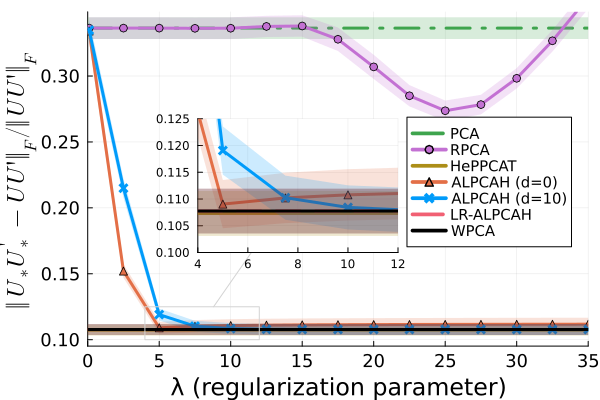

In [90]:
plot(xlabel="λ (regularization parameter)",ylabel=L"\Vert U_{*} U_{*}^{'}- UU' \Vert_F/ \Vert UU' \Vert_F");
plot!(legend_position=:topright, legendfontpointsize=10,xtickfontsize=12,ytickfontsize=12,guidefontsize=16,titlefontsize=18, legend=:right)
hline!([pca_mean],ribbon=pca_std,c=colors[3], fillalpha = 0.2,linewidth=3, label="PCA", linestyle=:dashdot)
plot!(λr_alpcah,rpca_mean, ribbon=rpca_std, fillalpha = 0.2, c=colors[4], linewidth=3, label="RPCA", markershape=:o)
hline!([heppcat_mean],ribbon=heppcat_std, c=colors[5], fillalpha = 0.2, linewidth=3, label="HePPCAT")
plot!(λr_alpcah,alpcah_nuclear_mean, ribbon=alpcah_nuclear_std, fillalpha = 0.2, c=colors[2], linewidth=3, label="ALPCAH (d=0)", markershape=:uptriangle)
plot!(λr_alpcah,alpcah_mean, ribbon=alpcah_std, fillalpha = 0.2, c=colors[1], linewidth=3, label="ALPCAH (d=10)", markershape=:x)
hline!([alpcah_lr_mean],ribbon=alpcah_lr_std, c=colors[end-2], fillalpha = 0.2, linewidth=3, label="LR-ALPCAH", linestyle=:dash)
hline!([wpca_mean],ribbon=wpca_std, c=:black, linewidth=3,fillalpha = 0.2, label="WPCA")
plot!(ylim=(wpca_mean-3*wpca_std, pca_mean + 1.5pca_std))
plot!(xlim=(0,35))
lens!([4, 12], [0.1, 0.125], inset = (1, bbox(0.22, 0.32, 0.4, 0.4)), xaxis=true, yaxis=true)
#savefig("known_variance.svg")